# Assignment 8: BHC Analysis using Python
#### Group: Mitchell Kramer, Nicholas Meyer,  Nikita Tatarinov, Glenn Matlin, Michael Galarnyk

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from tqdm import tqdm
from math import ceil

# Feel free to add or remove libraries as you see fit
from scipy.stats import skew, kurtosis
from scipy.stats import ttest_1samp
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acovf
from statsmodels.stats.sandwich_covariance import cov_hac

## Assignment Description

The goal of the assignment is to understand banks financial statements and the risks they are
exposed to. There are a number of issues (listed below) that I want the students to address
in the assignment report. Each group is expected to pick a bank or bank holding company.

1. Draw a random number generated using one of the team member gtid as a seed over theinterval (1, 25). List the seed and your random number at the top of the report.
2. You can select the random number using Python
3. Select the corresponding bank (rank based on size that is the same as the random number) at https://www.ffiec.gov/npw/Institution/TopHoldings
4. If the BHC is not publicly listed in the U.S., redraw the random number
5. I will cold call students in class to describe their findings about their assigned bank in the class

In [ ]:
# Dictionary provided by the user
group_id = {
    "Glenn Matlin": 903738044,
    "Nikita Tatarinov": 903914813,
    "Michael Galarnyk": 903918895,
    "Mitchell Kramer": 903176941,
    "Nicholas Meyer": 903444783
}

# Initialize a list to hold the random numbers
random_numbers = []

# Iterate over the GTIDs in the group_id dictionary
# For each GTID, we set it as the seed and generate a random number
for name, gtid in group_id.items():
    np.random.seed(gtid)  # Set the seed
    random_num = np.random.randint(1, 26)  # Generate the random number
    random_numbers.append(random_num)  # Append to the list

# Create a DataFrame from the group_id dictionary and the list of random numbers
df = pd.DataFrame(list(group_id.items()), columns=['Student', 'GTID'])
df['Random_Number'] = random_numbers  # Add the random numbers to the DataFrame


In [ ]:
holding_df = pd.read_csv("data/LargeHoldingCompanies.csv")

# Get Bank Names
df = pd.merge(df,
         holding_df,
         left_on='Random_Number', right_on='Rank', how='left')

In [ ]:
df

## Section 1: Current Information about the bank

This section should be brief. One paragraph.
1. What are the various business units of the bank (for example, is the bank a pure commercial bank or does it engage in investment banking and other financial businesses?). You can get this information from the firm’s 10-K.

## Section 2: Understand the Ownership Structure

Analyze (see yahoo finance or Bloomberg or the company’s investor website for the ownership structure). The data needs to be extracted using Python from the relevant URL. This section should be brief. One paragraph with data tables / graphs in the appendix.
1. Institutional Ownership
2. Non-Institutional Ownership
3. Insider Ownership
4. Are the insiders buying or selling the stock recently?

## Section 3: How do the markets view the bank

This section should be a short summary with the corresponding tables in the Appendix
1. Stock Return, Beta, Volatility (compute using Python, translate your previous Rcode into Python)
2. Short-interest in the bank’s stock. days it takes to cover the short-interest (from the exchange or other sources)
3. CDS prices (from bloomberg or some other source). Can show a graph using this data
4. Credit ratings
5. Analyst opinions

## Section 4: Understanding Bank Call Reports

To help with section 5-8 below, first do the following
1. Download the PDF format of the quarterly FRY9-C (as of Dec 2022) for your bank by following your bank link
* https://www.ffiec.gov/npw/Institution/TopHoldings
2. Browse through the statement (you can use control+f to find some of the items) to get the relevant item number for some of the following variables
3. In order to understand the variables, you can see FDIC performance report and description of the ratios.
* https://www.federalreserve.gov/boarddocs/supmanual/bhcpr/UsersGuide13/default.htm
4. Now download the Q4 (as of Dec 12/31) FRY9-C for for the bank for the last five years in CSV format (not manually, make a call inside your python program) by following the bank URL
5. Keep only the variables required for sections 5-8. Stack the quarterly data
6. Plot the variables for the past five years
7. Comment on the patterns that you observe in the data. 1-2 lines per variable. Discuss in the group first.

## Section 5: Performance and Financial Position of the Bank: Very Important

From the FRY9-C (10-K when needed), compute and graph these items over the past 5 years.
1. earnings
2. net interest margins
3. non-interest or fee income
4. revenues, expenses
5. loan mix
6. past due and losses
7. losses and loan reserves
8. liquidity and funding
9. capitalization ratios
10. growth rates
11. asset composition
12. liability composition
13. liquidity and funding (important)
14. maturity gap
15. interest rate sensitivity
16. what is the major source of the bank performance?
17. how did the bank perform compared to the peers? You can get this information from the BHC Performance Report

In [9]:
csv_files = {
# MS: Morgan Stanley
    ('MS', '2022'): 'data/MS_FRY9C_20221231.csv', 
    ('MS', '2021'): 'data/MS_FRY9C_20211231.csv',
    ('MS', '2020'): 'data/MS_FRY9C_20201231.csv',
    ('MS', '2019'): 'data/MS_FRY9C_20191231.csv',
    ('MS', '2018'): 'data/MS_FRY9C_20181231.csv',
# GS: Goldman Sachs
    ('GS', '2022'): 'data/GS_FRY9C_20221231.csv', 
    ('GS', '2021'): 'data/GS_FRY9C_20211231.csv',
    ('GS', '2020'): 'data/GS_FRY9C_20201231.csv',
    ('GS', '2019'): 'data/GS_FRY9C_20191231.csv',
    ('GS', '2018'): 'data/GS_FRY9C_20181231.csv',
# JPM: JP Morgan Chase
    ('JPM', '2022'): 'data/JPM_FRY9C_20221231.csv', 
    ('JPM', '2021'): 'data/JPM_FRY9C_20211231.csv',
    ('JPM', '2020'): 'data/JPM_FRY9C_20201231.csv',
    ('JPM', '2019'): 'data/JPM_FRY9C_20191231.csv',
    ('JPM', '2018'): 'data/JPM_FRY9C_20181231.csv'
}

fry9c_codes = {
    'Net Income (Loss)': 'BHCK4340',  # Net income (loss) attributable to the bank holding company
    'Net Interest Income': 'BHCK4074',  # Net interest income (interest income minus interest expenses)
    'Total Noninterest Income': 'BHCK4079',  # Total noninterest income (sum of noninterest income excluding realized gains/losses)
    'Total Interest Income': 'BHCK4107',  # Total interest income (interest and fee income on loans and leases)
    'Total Noninterest Expense': 'BHCK4093',  # Total noninterest expense (operating expenses including salaries and wages)
    'Total Loans and Leases': 'BHCK2122',  # Total loans and leases, net of unearned income
    'Past Due and Nonaccrual Loans': 'BHCKF640',  # Loans past due 90 days or more and still accruing and nonaccrual loans
    'Provision for Loan and Lease Losses': 'BHCKJJ33',  # Provision for loan and lease losses
    'Total Liabilities and Equity Capital': 'BHCK3300',  # Total liabilities and equity capital
    'Total Capital Ratio': 'BHCA7205',  # Total risk-based capital ratio
    'Leverage Ratio': 'BHCA7204',  # Tier 1 (core) leverage ratio
    'Total Assets': 'BHCK2170',  # Total consolidated assets
    'Total Liabilities': 'BHCK2948',  # Total liabilities (excludes equity)
    # 'Maturity Gap': N/A,  # The difference between the amounts of assets and liabilities maturing within a certain time frame
    # 'Interest Rate Sensitivity': N/A  # Measures the change in net interest income due to changes in interest rates
}

df_dict = {}

for (company, year), filepath in csv_files.items():
    df_temp = pd.read_csv(filepath)
    df_temp = df_temp[df_temp['ItemName'].str.startswith(('BHCK', 'BHCA'))]
    df_temp.set_index('ItemName', inplace=True)
    df_temp['Company'] = company
    df_temp['Year'] = pd.to_datetime(year, format='%Y')
    df_temp.set_index(['Company', 'Year'], append=True, inplace=True)
    df_dict[(company, year)] = df_temp

df = pd.concat(df_dict.values())
df.sort_index(inplace=True)
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
df = df.dropna(subset=['Value'])

multi_index_df = pd.DataFrame(index=pd.MultiIndex.from_product([df.index.get_level_values('Company').unique(), 
                                                                df.index.get_level_values('Year').unique()], 
                                                               names=['Company', 'Year']), 
                              columns=fry9c_codes.keys())

for company, year in multi_index_df.index:
    for col_name, item_code in fry9c_codes.items():
        value = df.xs((item_code, company, year), level=[0, 'Company', 'Year'])['Value']
        if item_code.startswith('BHCK'):
            adjusted_value = value * 1000 # "Dollar Amounts in Thousands"
        else:
            adjusted_value = value
        multi_index_df.at[(company, year), col_name] = adjusted_value.iloc[0] if not adjusted_value.empty else pd.NA

multi_index_df.applymap(lambda y: 
                               f"${y / 1e12:.2f}T" if not pd.isna(y) and np.abs(y) >= 1e12 else 
                               (f"${y / 1e9:.2f}B" if not pd.isna(y) and np.abs(y) >= 1e9 else 
                               (f"${y / 1e6:.2f}M" if not pd.isna(y) and np.abs(y) >= 1e6 else 
                               (f"${y / 1e3:.2f}K" if not pd.isna(y) and np.abs(y) >= 1e3 else 
                               (f"{y:.2f}" if not pd.isna(y) else y)))))

Net Income (Loss) Net Interest Income  \
Company Year                                               
GS      2018-01-01           $10.46B              $3.78B   
        2019-01-01            $8.47B              $4.37B   
        2020-01-01            $9.46B              $4.75B   
        2021-01-01           $21.64B              $6.47B   
        2022-01-01           $11.26B              $7.68B   
JPM     2018-01-01           $32.47B             $55.40B   
        2019-01-01           $36.43B             $57.59B   
        2020-01-01           $29.13B             $55.00B   
        2021-01-01           $48.33B             $52.54B   
        2022-01-01           $37.68B             $67.13B   
MS      2018-01-01            $8.75B              $6.55B   
        2019-01-01            $9.04B              $6.67B   
        2020-01-01           $11.00B              $7.90B   
        2021-01-01           $15.03B             $10.00B   
        2022-01-01           $11.03B             $10.84B   

                   Total Noninterest Income Total Interest Income  \
Company Year                                                        
GS      2018-01-01                  $32.91B               $19.69B   
        2019-01-01                  $32.24B               $21.74B   
        2020-01-01                  $39.57B               $13.69B   
        2021-01-01                  $52.80B               $12.12B   
        2022-01-01                  $39.72B               $29.03B   
JPM     2018-01-01                  $54.07B               $77.78B   
        2019-01-01                  $58.46B               $84.39B   
        2020-01-01                  $64.17B               $64.96B   
        2021-01-01                  $69.39B               $58.24B   
        2022-01-01                  $62.99B               $93.23B   
MS      2018-01-01                  $33.48B               $16.64B   
        2019-01-01                  $34.66B               $19.07B   
        2020-01-01                  $40.58B               $11.75B   
        2021-01-01                  $49.56B               $11.37B   
        2022-01-01                  $43.02B               $23.11B   

                   Total Noninterest Expense Total Loans and Leases  \
Company Year                                                          
GS      2018-01-01                   $23.48B               $127.63B   
        2019-01-01                   $24.97B               $146.55B   
        2020-01-01                   $29.23B               $186.21B   
        2021-01-01                   $31.94B               $247.29B   
        2022-01-01                   $31.16B               $236.74B   
JPM     2018-01-01                   $63.45B                 $1.01T   
        2019-01-01                   $66.22B               $993.49B   
        2020-01-01                   $68.24B                 $1.06T   
        2021-01-01                   $71.78B                 $1.14T   
        2022-01-01                   $75.70B                 $1.18T   
MS      2018-01-01                   $28.82B               $150.64B   
        2019-01-01                   $30.10B               $172.66B   
        2020-01-01                   $33.74B               $235.12B   
        2021-01-01                   $40.03B               $269.65B   
        2022-01-01                   $39.29B               $258.28B   

                   Past Due and Nonaccrual Loans  \
Company Year                                       
GS      2018-01-01                      $311.00M   
        2019-01-01                      $214.00M   
        2020-01-01                      $195.00M   
        2021-01-01                      $790.00M   
        2022-01-01                       $23.00M   
JPM     2018-01-01                        $3.71B   
        2019-01-01                        $3.37B   
        2020-01-01                        $3.24B   
        2021-01-01                        $3.06B   
        2022-01-01                        $2

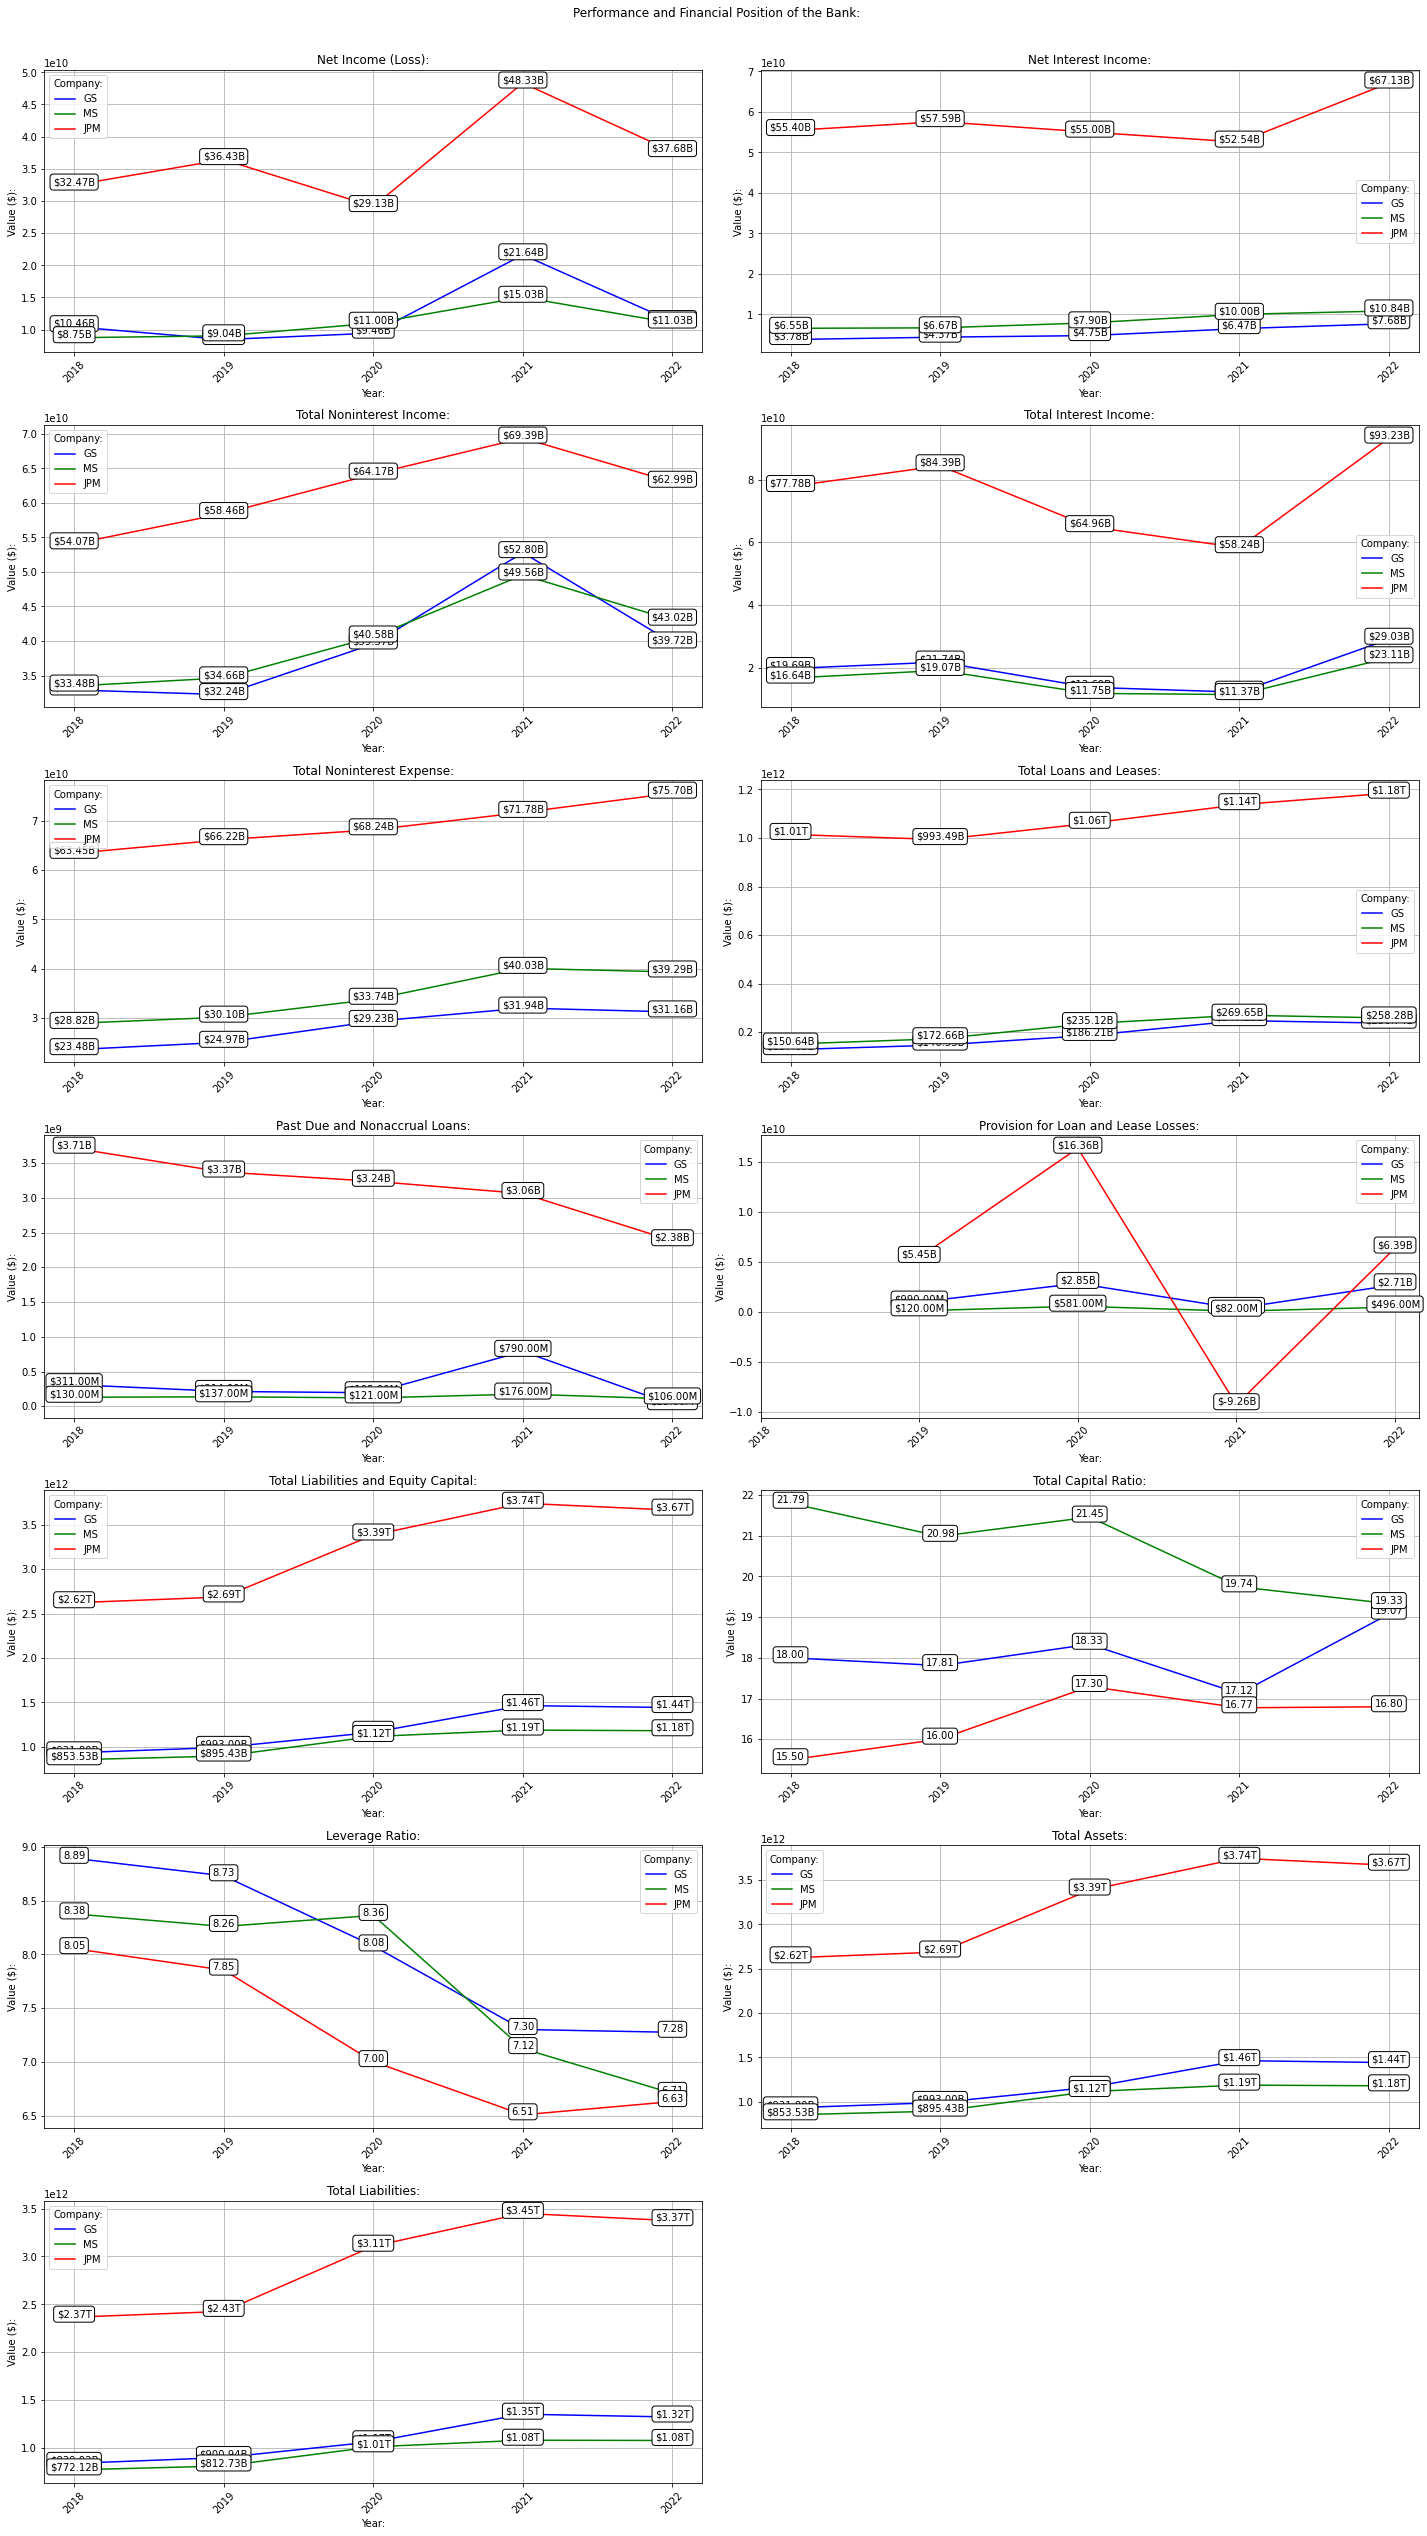

In [10]:
num_items = len(fry9c_codes)
num_rows = ceil(num_items / 2)

fig, axes = plt.subplots(num_rows, 2, figsize=(20, num_rows * 5))

if num_items % 2:
    fig.delaxes(axes[-1, -1])

axes = axes.flatten()

colors = {'GS': 'blue', 'MS': 'green', 'JPM': 'red'}

current_subplot = 0

for col_name in fry9c_codes.keys():
    for company in colors.keys():
        data = multi_index_df.xs(company, level='Company')[col_name]
        data = data.replace(pd.NA, np.nan).astype(float)
        years = data.index.get_level_values('Year').strftime('%Y').astype(int)
        axes[current_subplot].plot(years, data, label=company, color=colors[company])

        for x, y in zip(years, data):
            if np.isnan(y):
                continue

            if np.abs(y) >= 1e12:  # Trillions
                value_str = f'${y / 1e12:.2f}T'
            elif np.abs(y) >= 1e9:  # Billions
                value_str = f'${y / 1e9:.2f}B'
            elif np.abs(y) >= 1e6:  # Millions
                value_str = f'${y / 1e6:.2f}M'
            elif np.abs(y) >= 1e3:  # Thousands
                value_str = f'${y / 1e3:.2f}K'
            else:  # Less than a million
                value_str = f'{y:.2f}'

            axes[current_subplot].annotate(value_str,
                                           (x, y),
                                           textcoords="offset points",
                                           xytext=(0,0),
                                           ha='center',
                                           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=1))

    axes[current_subplot].set_title(col_name + ":")
    axes[current_subplot].set_ylabel('Value ($):')
    axes[current_subplot].set_xlabel('Year:')
    axes[current_subplot].legend(title='Company:')

    axes[current_subplot].tick_params(axis='x', rotation=45)
    axes[current_subplot].set_xticks(years)
    axes[current_subplot].set_xticklabels(years)

    axes[current_subplot].grid()
    current_subplot += 1

fig.suptitle("Performance and Financial Position of the Bank:", y=1.005)
plt.tight_layout()
plt.show()

## Section 6: Risk Profile of the Bank from Management Discussion and Analysis (MD&A) section in 10-K or 10-Q

1. Download the latest 10-K for the bank. If it is not in 2023, you may need to check latest 10-Q.
2. Go to the Management Discussion of Risk Management in the Management Discussion and Analysis (MD&A) section
3. Based on MD&A discussion,
    
    1). Is there a Asset Liability Committe (ALCO)? Describe the framework that the bank
is using for Asset Liability Management (ALM) within the bank
    
    2). Interest Rate Risk
        * How is the bank measuring and managing interest rate risk for ALM?
        * Do they discuss duration and convexity in the context of ALM?
4. How does the bank discuss Liquidity Risk Management?
    * What are some tools and metrics that the bank is using for liquidity risk management?
    * Di they discuss deposit convexity after SVB crisis? (mostly from their 10-Q)
5. Does the bank discuss how Basel III regulations affect their ALM strategies?
6. Describe the banks ALM Models and Assumptions if they disclosed it? How do they validate their ALM models?
7. How is the bank modeling deposits and loan book? What factors are they considering? Is there a scenario analysis?
8. How is the bank adapting their ALM strategy to the rising interest rate environments (may need to see latest 10-Q)
9. Do they discuss any other strategic considerations for ALM strategy and how it fits in the broad risk management framework?

## Section 7: Risk Profile of the Bank from FRY9-C and 10-K / 10-Q

Analyze the risk profile of the bank (under the same headings as the bank risks lecture).
1. Pay special attention to operational risk (fraud etc,)
2. Asset Side Risks
3. Liability side risks
4. Off-balance-sheet risks
5. Regulatory Risk
6. Exposure to real estate markets

In [144]:
csv_file = 'data/JPM_FRY9C_20221231.csv'

codes = {
    'Total risk-weighted assets (item 28 minus items 29 and 30)': 'BHCKG641',
    'Total capital (sum of items 26 and 44.a)': 'BHCA3792',
    'Total loans and leases (sum of items 1 through 8.b) Past due 30 through 89 days and still accruing': 'BHCK1406',
    'Total loans and leases (sum of items 1 through 8.b) Past due 90 days or more and still accruing' : 'BHCK1407', 
    'Total loans and leases (sum of items 1 through 8.b) Nonaccrual': 'BHCK1403',
    'Total loans and leases held for investment and held for sale': 'BHCK2122',
    'Total liabilities (sum of items 13 through 20)': 'BHCK2948',
    'Total liabilities and equity capital (sum of items 21 and 28)': 'BHCK3300',
    'Total leverage exposure for the supplementary leverage ratio (SLR)': 'BHCALE88',
    'Total assets (sum of items 1 through 11)' : 'BHCK2170',
    'Provision for loan and lease losses': 'BHCKJJ33',
    'Total assets (sum of items 1 through 11)' : 'BHCK2170',
    'Current credit exposure across all derivative contracts covered by the regulatory capital rules': 'BHCKG642',
    'Total risk-weighted assets (item 28 minus items 29 and 30)': 'BHCKG641',
    'High volatility commercial real estate exposures': 'BHCKS445',
    'Total assets (sum of items 1 through 11)' : 'BHCK2170'
}

df = pd.read_csv('data/JPM_FRY9C_20221231.csv')
df = df[df['ItemName'].isin(codes.values())]
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
df.drop('Description', axis=1, inplace=True)
df.set_index('ItemName', inplace=True)

# Operational Risk:
    # Operational Risk Capital Ratio = Risk-Weighted Assets / Operational Risk Capital
df.loc['(Operational Risk) Operational Risk Capital Ratio'] = (df.loc[codes['Total risk-weighted assets (item 28 minus items 29 and 30)']] /
                                           df.loc[codes['Total capital (sum of items 26 and 44.a)']])
# Asset Side Risks:
    # NPL Ratio = Non-Performing Loans / Total Loans
df.loc['(Asset Side Risks) NPL Ratio'] = ((df.loc[codes['Total loans and leases (sum of items 1 through 8.b) Past due 30 through 89 days and still accruing']] +
                       df.loc[codes['Total loans and leases (sum of items 1 through 8.b) Past due 90 days or more and still accruing']] +
                       df.loc[codes['Total loans and leases (sum of items 1 through 8.b) Nonaccrual']])
                       / df.loc[codes['Total loans and leases held for investment and held for sale']])
# Liability Side Risks:
    # Net Stable Funding Ratio = Available Stable Funding / Required Stable Funding
df.loc['(Liability Side Risks) Net Stable Funding Ratio'] = (df.loc[codes['Total leverage exposure for the supplementary leverage ratio (SLR)']] / 
                                      df.loc[codes['Total liabilities and equity capital (sum of items 21 and 28)']])
    # Supplementary Leverage Ratio (SLR) = Total leverage exposure for the supplementary leverage ratio (SLR) / Total assets
df.loc['(Liability Side Risks) Supplementary Leverage Ratio (SLR)'] = (df.loc[codes['Total liabilities (sum of items 13 through 20)']] / 
                                            df.loc[codes['Total assets (sum of items 1 through 11)']])
# Off-Balance-Sheet Risks:
    # Off-Balance-Sheet Exposure Ratio =  Off-Balance-Sheet Exposure / Total Assets
df.loc['(Off-Balance-Sheet Risks) Off-Balance-Sheet Exposure Ratio'] = (df.loc[codes['Provision for loan and lease losses']] / 
                                          df.loc[codes['Total assets (sum of items 1 through 11)']])
# Regulatory Risk:
    # Regulatory Capital Ratio = Regulatory Capital / Risk-Weighted Assets
df.loc['(Regulatory Risk) Regulatory Capital Ratio'] = (df.loc[codes['Current credit exposure across all derivative contracts covered by the regulatory capital rules']] / 
                                  df.loc[codes['Total risk-weighted assets (item 28 minus items 29 and 30)']])
# Exposure to Real Estate Markets:
    # Real Estate Exposure Ratio = Real Estate Exposure / Total Assets
df.loc['(Exposure to Real Estate Markets) Real Estate Exposure Ratio'] = (df.loc[codes['High volatility commercial real estate exposures']] / 
                                  df.loc[codes['Total assets (sum of items 1 through 11)']])

df.drop(codes.values(), inplace=True)
for index, row in df.iterrows():
    print(index + ":" , round(row['Value'], 3))

(Operational Risk) Operational Risk Capital Ratio: 5.953
(Asset Side Risks) NPL Ratio: 0.012
(Liability Side Risks) Net Stable Funding Ratio: 1.191
(Liability Side Risks) Supplementary Leverage Ratio (SLR): 0.92
(Off-Balance-Sheet Risks) Off-Balance-Sheet Exposure Ratio: 0.002
(Regulatory Risk) Regulatory Capital Ratio: 0.048
(Exposure to Real Estate Markets) Real Estate Exposure Ratio: 0.0


## Section 8: Off-balance sheet activities of the Bank from FRY9-C and 10-K / 10-Q

1. Off balance sheet growth over years
2. Components of off-balance sheet
3. Bank’s Derivative Usage. What are the biggest components?
4. Securitization activities
5. Level 1, Level 2 and Level 3 assets of the bank
6. Value at Risk, Expected Shortfall and other Risk Measures noted in the 10-K/10-Q

## Additional Comments

Note:
1. You are expected to learn some new material through this assignment, in addition to the material covered through lectures in the class
2. Present the information in a graphical format to the extent possible. Use Python to generate graphs
3. Part of the task is to decide which financial information is relevant and which is not.
4. Focus on both income statement and balance sheet

## Resources

1. FDIC, NIC and FFIEC websites
2. <b>important </b>https://www.federalreserve.gov/boarddocs/supmanual/bhcpr/UsersGuide13/0313.pdf
3. http://www.federalreserve.gov/boarddocs/supmanual/default.htm#bhcuser
4. https://www.fdic.gov/search/help.html
5. http://www.ffiec.gov/nicpubweb/nicweb/nichome.aspx
6. See the Bank Holding Company Performance Report (BHCPR) at
    * https://www.ffiec.gov/npw/Institution/TopHoldings.
    * Click on your respective bank and then select BHCPR